<a href="https://colab.research.google.com/github/yyRegis/projeto-idc/blob/main/ScriptIDC_Arvore_de_Decisao_no_R.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Abrir colab com R

Link: https://colab.research.google.com/#create=true&language=r

Atualizado em: 01.2025

### Árvore de Decisão

In [1]:
# <> ----------------------------
# <> Instalando bibliotecas
install.packages("tidymodels")
install.packages("rpart.plot")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘shape’, ‘numDeriv’, ‘progressr’, ‘SQUAREM’, ‘diagram’, ‘lava’, ‘prodlim’, ‘warp’, ‘future.apply’, ‘iterators’, ‘listenv’, ‘parallelly’, ‘lhs’, ‘DiceDesign’, ‘sfd’, ‘sparsevctrs’, ‘patchwork’, ‘globals’, ‘clock’, ‘gower’, ‘ipred’, ‘timeDate’, ‘furrr’, ‘slider’, ‘doFuture’, ‘foreach’, ‘future’, ‘GPfit’, ‘modelenv’, ‘dials’, ‘hardhat’, ‘infer’, ‘modeldata’, ‘parsnip’, ‘recipes’, ‘rsample’, ‘tune’, ‘workflows’, ‘workflowsets’, ‘yardstick’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [2]:
# <> ----------------------------
# Lendo bibliotecas
library(tidymodels)
library(yardstick)

── Attaching packages ────────────────────────────────────── tidymodels 1.3.0 ──

✔ broom        1.0.7     ✔ recipes      1.2.0
✔ dials        1.4.0     ✔ rsample      1.2.1
✔ dplyr        1.1.4     ✔ tibble       3.2.1
✔ ggplot2      3.5.1     ✔ tidyr        1.3.1
✔ infer        1.0.7     ✔ tune         1.3.0
✔ modeldata    1.4.0     ✔ workflows    1.2.0
✔ parsnip      1.3.1     ✔ workflowsets 1.1.0
✔ purrr        1.0.4     ✔ yardstick    1.3.2

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ purrr::discard() masks scales::discard()
✖ dplyr::filter()  masks stats::filter()
✖ dplyr::lag()     masks stats::lag()
✖ recipes::step()  masks stats::step()



In [74]:
# <> ----------------------------
# <> Para conflitos de funções, usar a do tidymodels
tidymodels_prefer()

In [75]:
# <> ----------------------------
# <> Trabalhando com os dados two_class_dat
# Assuming your CSV file is named 'student_admission_record_dirty.csv'
df <-read.csv("student_admission_record_dirty.csv")
# Read data from 'student_admission_record_dirty.csv' file
head(df) # Display the first few rows


,Name,Age,Gender,Admission.Test.Score,High.School.Percentage,City,Admission.Status
,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<chr>
1,Shehroz,24,Female,50,68.90,Quetta,Rejected
2,Waqar,21,Female,99,60.73,Karachi,
3,Bushra,17,Male,89,NA,Islamabad,Accepted
4,Aliya,17,Male,55,85.29,Karachi,Rejected
5,Bilal,20,Male,65,61.13,Lahore,
6,Murtaza,23,Female,NA,NA,Islamabad,Accepted


In [217]:
# Remover colunas irrelevantes
df <- df[, !(names(df) %in% c("Name", "City"))]

# Corrigir valores negativos
df$Age[df$Age < 0] <- NA
df$Admission.Test.Score[df$Admission.Test.Score < 0] <- NA
df$High.School.Percentage[df$High.School.Percentage < 0] <- NA

# Remover outliers extremos
percentile_99 <- apply(df[, c("Admission.Test.Score", "High.School.Percentage")], 2, quantile, 0.99, na.rm = TRUE)
df <- df[df$Admission.Test.Score <= percentile_99["Admission.Test.Score"] &
         df$High.School.Percentage <= percentile_99["High.School.Percentage"], ]

# Preencher valores ausentes com mediana (para números) e moda (para categorias)
df$Age[is.na(df$Age)] <- median(df$Age, na.rm = TRUE)
df$Admission.Test.Score[is.na(df$Admission.Test.Score)] <- median(df$Admission.Test.Score, na.rm = TRUE)
df$High.School.Percentage[is.na(df$High.School.Percentage)] <- median(df$High.School.Percentage, na.rm = TRUE)
df$Gender[is.na(df$Gender)] <- names(sort(table(df$Gender), decreasing = TRUE))[1]

# Define the Mode function
Mode <- function(x) {
  ux <- unique(x)
  ux[which.max(tabulate(match(x, ux)))]
}
# Remover valores ausentes em 'Admission Status'
df <- df[!is.na(df$Admission.Status), ]



# Converter variáveis categóricas para fator
df$Gender <- as.factor(df$Gender)
df$Admission.Status <- as.factor(df$Admission.Status)





In [199]:
names(df)

[1] "Age"                    "Gender"                 "Admission.Test.Score"  
[4] "High.School.Percentage" "Admission.Status"

In [218]:


# <> ----------------------------
# <> Verificando proporcao total por classe
df |>
  count(Admission.Status) |>
  mutate(prop = n/sum(n))

Admission.Status,n,prop
<fct>,<int>,<dbl>
,7,0.05932203
Accepted,59,0.50000000
Rejected,52,0.44067797


In [219]:
# <> ----------------------------
# <> Selecionando Amostra de Treinamento e Teste
set.seed(123)
cell_split <- initial_split(df,
                            strata = Admission.Status ,
                            prop = 0.7)

In [220]:
# <> ----------------------------
# <> Dividindo em treinamento e teste
data_train <- training(cell_split)
data_test  <- testing(cell_split)

In [221]:
# <> ----------------------------
# <> Verificando proporcao dados treinamento
data_train |>
  count(Admission.Status) |>
  mutate(prop = n/sum(n))

Admission.Status,n,prop
<fct>,<int>,<dbl>
,5,0.06097561
Accepted,42,0.51219512
Rejected,35,0.42682927


In [222]:
# <> ----------------------------
# <> Verificando proporcao dados teste
data_test |>
  count(Admission.Status) |>
  mutate(prop = n/sum(n))

Admission.Status,n,prop
<fct>,<int>,<dbl>
,2,0.05555556
Accepted,17,0.47222222
Rejected,17,0.47222222


In [223]:
# <> ----------------------------
# <> Definimos o modelo e os parâmetros
dt_cls_spec <-
  decision_tree(tree_depth = 10) |> #tree_depth  => profundidade máxima da árvore
  # This model can be used for classification or regression, so set mode
  set_mode("classification") |>
  set_engine("rpart")

In [224]:
dt_cls_spec

Decision Tree Model Specification (classification)

Main Arguments:
  tree_depth = 10

Computational engine: rpart 


In [225]:
# <> ----------------------------
# <> Vamos fazer o 'treinamento' do modelo
set.seed(1)
dt_cls_fit <- dt_cls_spec |>
  fit(Admission.Status  ~ ., data = data_train)


In [226]:
# <> Visualizando o modelo
dt_cls_fit

parsnip model object

n= 82 

node), split, n, loss, yval, (yprob)
      * denotes terminal node

 1) root 82 40 Accepted (0.06097561 0.51219512 0.42682927)  
   2) High.School.Percentage>=60.73 70 30 Accepted (0.07142857 0.57142857 0.35714286)  
     4) High.School.Percentage< 77.185 29 16 Accepted (0.13793103 0.44827586 0.41379310)  
       8) Admission.Test.Score>=69.5 22 10 Accepted (0.13636364 0.54545455 0.31818182)  
        16) High.School.Percentage< 68.2 9  2 Accepted (0.11111111 0.77777778 0.11111111) *
        17) High.School.Percentage>=68.2 13  7 Rejected (0.15384615 0.38461538 0.46153846) *
       9) Admission.Test.Score< 69.5 7  2 Rejected (0.14285714 0.14285714 0.71428571) *
     5) High.School.Percentage>=77.185 41 14 Accepted (0.02439024 0.65853659 0.31707317)  
      10) High.School.Percentage< 79.05 8  0 Accepted (0.00000000 1.00000000 0.00000000) *
      11) High.School.Percentage>=79.05 33 14 Accepted (0.03030303 0.57575758 0.39393939)  
        22) Age>=19.5 24  

Warning message:
“Cannot retrieve the data used to build the model (so cannot determine roundint and is.binary for the variables).
To silence this warning:
    Call rpart.plot with roundint=FALSE,
    or rebuild the rpart model with model=TRUE.”


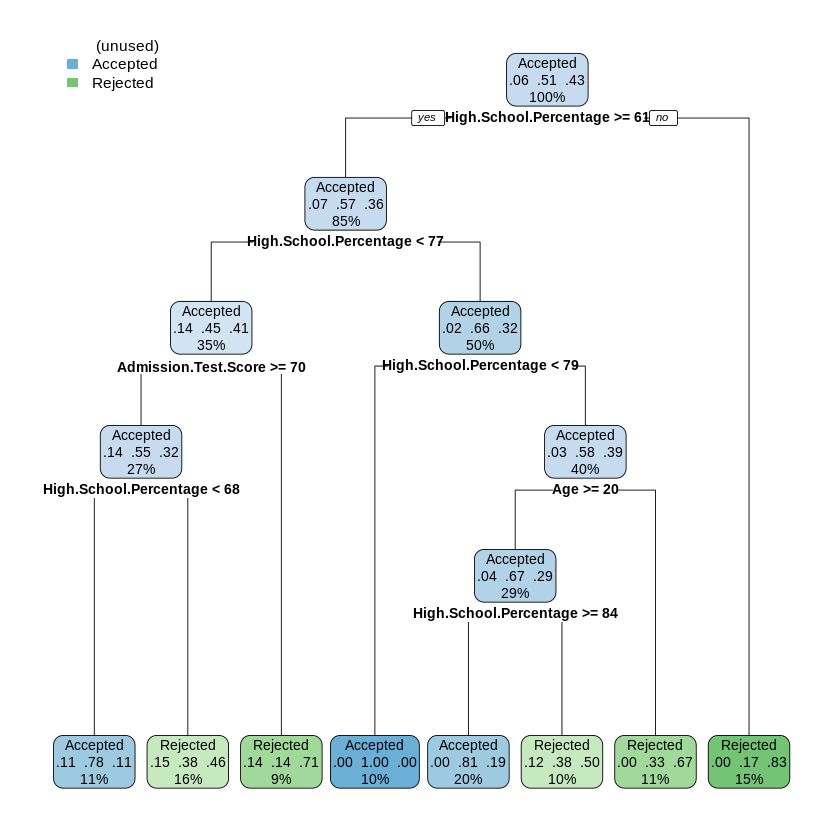

In [227]:
# <> ----------------------------
# <> Fazendo o plot do modelo
dt_cls_fit |>
  extract_fit_engine() |>
  rpart.plot::rpart.plot()

In [228]:
# <> ----------------------------
# <> Fazendo o predição do resultado e adicionando coluna verdadeira
dt_testing_pred <-
  predict(dt_cls_fit, data_test) |>
  bind_cols(predict(dt_cls_fit, data_test, type = "prob")) |>
  bind_cols(data_test |> select(Admission.Status))

In [229]:
dt_testing_pred

,.pred_class,.pred_V1,.pred_Accepted,.pred_Rejected,Admission.Status
,<fct>,<dbl>,<dbl>,<dbl>,<fct>
1,Rejected,0.1428571,0.1428571,0.7142857,Rejected
2,Rejected,0.0000000,0.1666667,0.8333333,
3,Rejected,0.0000000,0.3333333,0.6666667,Rejected
4,Rejected,0.0000000,0.1666667,0.8333333,Accepted
5,Rejected,0.0000000,0.3333333,0.6666667,
6,Rejected,0.1538462,0.3846154,0.4615385,Rejected
7,Accepted,0.1111111,0.7777778,0.1111111,Rejected
8,Rejected,0.0000000,0.1666667,0.8333333,Rejected
9,Accepted,0.0000000,0.8125000,0.1875000,Rejected


In [230]:
# <> ----------------------------
# <> Fazendo avaliação do modelo na amostra de teste
dt_testing_pred |>
  accuracy(truth = Admission.Status, .pred_class)

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.5


--------

## Aplicando k-fold

In [231]:
# <> ----------------------------
# <> Fazendo treinamento com reamostragem - k-fold
set.seed(345)
folds <- vfold_cv(data_train, v = 5,strata =Admission.Status )

In [232]:
# <> ----------------------------
# <> Criando o workflow de treinamento
dt_wf <-
  workflow() |>
  add_model(dt_cls_spec) |>
  add_formula(Admission.Status ~ .)

In [233]:
# <> ----------------------------
# <> Aplicando o treinamento com k-fold
set.seed(456)
dt_fit_rs <-
  dt_wf |>
  fit_resamples(folds)

→ A | error:   Failed to compute `roc_auc()`.
               Caused by error:
               ! Can't select columns that don't exist.
               ✖ Column `.pred_` doesn't exist.

There were issues with some computations   A: x1

There were issues with some computations   A: x5



Warning message:
“All models failed. Run `show_notes(.Last.tune.result)` for more information.”


In [234]:
# <> ----------------------------
# <> Fazendo avaliação do modelo na amostra de teste
dt_testing_pred |>
  accuracy(truth = Admission.Status, .pred_class)

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.5
